In [1]:
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import spacy
import nltk
nlp=spacy.load('en_core_web_sm')
from nltk.tokenize import word_tokenize,sent_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
import string
from nltk.corpus import stopwords
nltk.download('all')
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (confusion_matrix, classification_report,accuracy_score, precision_score, recall_score, f1_score,roc_curve, auc)

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/abc.zip.
[nltk_data]    | Downloading package alpino to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/alpino.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger_eng to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping
[nltk_data]    |       taggers/averaged_perceptron_tagger_eng.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping
[nltk_data]    |       taggers/averaged_perceptron_tagger_ru.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger_rus to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |  

In [4]:
df=pd.read_csv('/content/amazonreviews (1).tsv', sep='\t')

In [5]:
df.shape

(10000, 2)

In [6]:
df.head()

,label,review
0,pos,Stuning even for the non-gamer: This sound tra...
1,pos,The best soundtrack ever to anything.: I'm rea...
2,pos,Amazing!: This soundtrack is my favorite music...
3,pos,Excellent Soundtrack: I truly like this soundt...
4,pos,"Remember, Pull Your Jaw Off The Floor After He..."


In [7]:
#data cleaning

In [9]:
#null values
df.isnull().sum()

,0
label,0
review,0


In [10]:
#duplicates
df.duplicated().sum()

np.int64(0)

In [11]:
#data cleaning
def clean_text(text):
  text=str(text).lower()
  text = re.sub(r'<[^>]+>', ' ', text)
  text = re.sub(r'[^a-z0-9\s]', ' ', text)
  text = re.sub(r'\s+', ' ', text).strip()
  return text


In [12]:
df['clean_review']=df['review'].apply(clean_text)

In [13]:
#exploratory analysis

In [14]:
#sentiment distribution

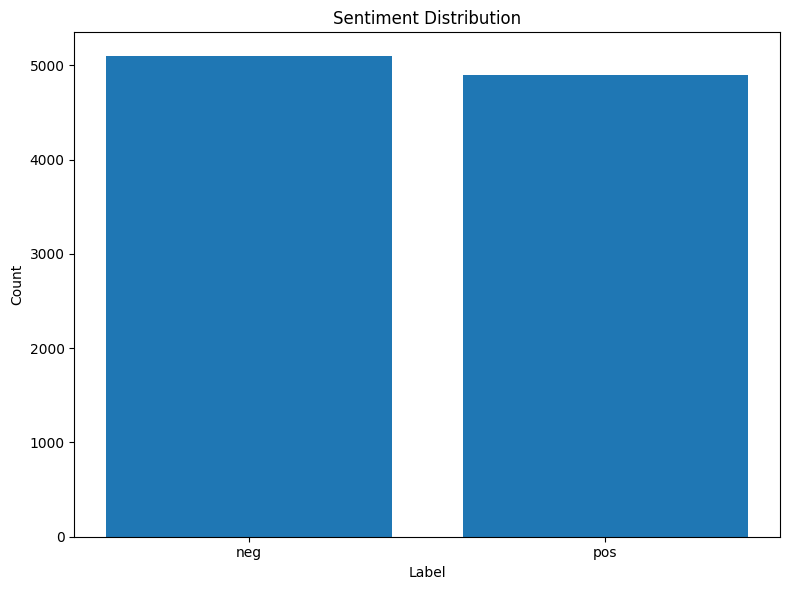

In [17]:
label_counts=df['label'].value_counts()
fig=plt.figure(figsize=(8,6))
plt.bar(label_counts.index.astype(str), label_counts.values)
plt.title("Sentiment Distribution")
plt.xlabel("Label")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

In [18]:
#most common postive and negitive words

In [19]:
def get_top_n_words(texts, n=20):
    c = Counter()
    for t in texts:
        c.update(t.split())
    return c.most_common(n)

In [20]:
top_pos = get_top_n_words(df[df['label']=='pos']['clean_review'], n=20)
top_neg = get_top_n_words(df[df['label']=='neg']['clean_review'], n=20)

In [21]:
top_pos_df = pd.DataFrame(top_pos, columns=['word','count'])
top_neg_df = pd.DataFrame(top_neg, columns=['word','count'])

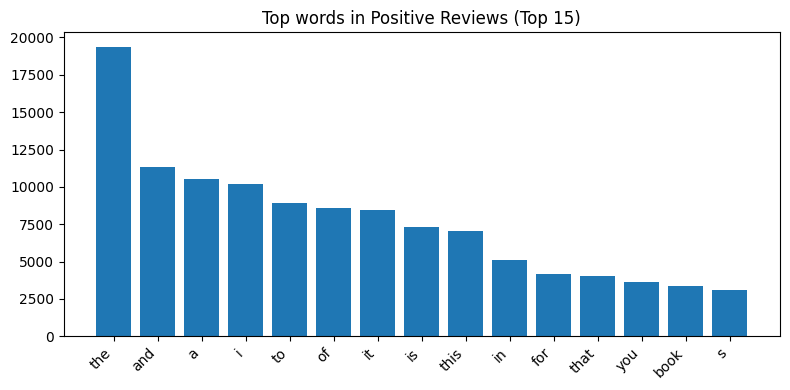

In [22]:
# Plot top words (positive)
fig = plt.figure(figsize=(8,4))
plt.bar([w for w,c in top_pos[:15]], [c for w,c in top_pos[:15]])
plt.xticks(rotation=45, ha='right')
plt.title("Top words in Positive Reviews (Top 15)")
plt.tight_layout()
plt.show()

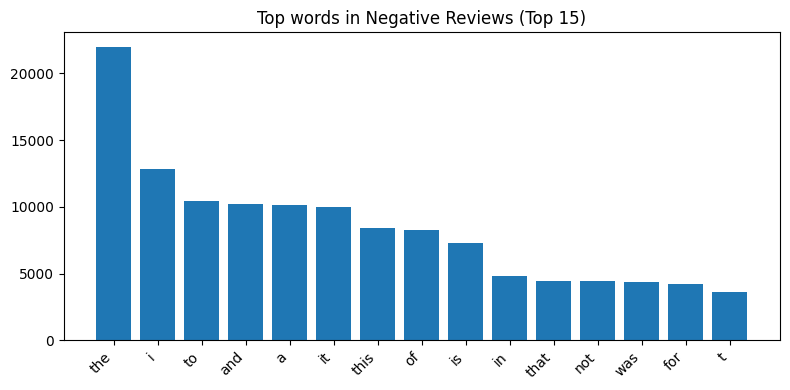

In [23]:
# Plot top words (negative)
fig = plt.figure(figsize=(8,4))
plt.bar([w for w,c in top_neg[:15]], [c for w,c in top_neg[:15]])
plt.xticks(rotation=45, ha='right')
plt.title("Top words in Negative Reviews (Top 15)")
plt.tight_layout()
plt.show()

In [24]:
#model deployment
#tf_idf technique

In [25]:
tfidf = TfidfVectorizer(ngram_range=(1,2), min_df=5, max_df=0.9, stop_words='english', max_features=20000)
X = tfidf.fit_transform(df['clean_review'])
y = df['label'].map({'pos':1, 'neg':0}).values

In [26]:
print("TF-IDF matrix shape:", X.shape)

TF-IDF matrix shape: (10000, 11861)


In [27]:
#Train/test split & model training
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=100)

In [28]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(8000, 11861)
(2000, 11861)
(8000,)
(2000,)


In [29]:
#logistic regression

In [30]:
model = LogisticRegression(max_iter=1000, solver='liblinear', random_state=100)
model.fit(X_train, y_train)

LogisticRegression(max_iter=1000, random_state=100, solver='liblinear')

In [31]:
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:,1]

In [32]:
y_proba

array([0.27201237, 0.15736445, 0.62468576, ..., 0.09368628, 0.09119648,
       0.88303035])

In [34]:
#validation

In [35]:
print("Classification report:")
print(classification_report(y_test, y_pred, target_names=['neg','pos']))

Classification report:
              precision    recall  f1-score   support

         neg       0.87      0.87      0.87      1019
         pos       0.86      0.86      0.86       981

    accuracy                           0.87      2000
   macro avg       0.87      0.87      0.87      2000
weighted avg       0.87      0.87      0.87      2000



In [36]:
#accuracy and f1 score

In [37]:
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
print("Test set metrics:")
print(f"Accuracy: {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall: {rec:.4f}")
print(f"F1-score: {f1:.4f}\n")

Test set metrics:
Accuracy: 0.8655
Precision: 0.8618
Recall: 0.8644
F1-score: 0.8631



In [38]:
#cross validation

In [39]:
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=100)
cv_scores = cross_val_score(model, X, y, cv=cv, scoring='accuracy', n_jobs=1)
print("3-fold CV accuracy mean: %.4f (std %.4f)" % (cv_scores.mean(), cv_scores.std()))

3-fold CV accuracy mean: 0.8571 (std 0.0033)


In [40]:
#Model Coefficients Inspection

In [41]:
features = np.array(tfidf.get_feature_names_out())
coef = model.coef_[0]
top_pos_idx = np.argsort(coef)[-20:][::-1]
top_neg_idx = np.argsort(coef)[:20]


In [42]:
print("Top features indicating positive sentiment:")
display(pd.DataFrame({'feature': features[top_pos_idx], 'coef': coef[top_pos_idx]}).head(15))

Top features indicating positive sentiment:


,feature,coef
0,great,7.500462
1,excellent,4.936071
2,best,4.289964
3,love,4.261840
4,good,3.392043
5,amazing,3.196075
6,easy,3.165903
7,perfect,3.143702
8,wonderful,3.112334
9,favorite,2.765137


In [43]:
print("Top features indicating negative sentiment:")
display(pd.DataFrame({'feature': features[top_neg_idx], 'coef': coef[top_neg_idx]}).head(15))

Top features indicating negative sentiment:


,feature,coef
0,boring,-5.021825
1,worst,-4.513409
2,bad,-4.297455
3,disappointed,-4.235324
4,poor,-4.101477
5,waste,-4.070686
6,money,-3.522900
7,disappointing,-3.146822
8,terrible,-2.795935
9,horrible,-2.583459


In [44]:
#result summary
results_summary = {
    'test_accuracy': acc,
    'test_precision': prec,
    'test_recall': rec,
    'test_f1': f1,
    'cv_accuracy_mean': cv_scores.mean(),
    'cv_accuracy_std': cv_scores.std(),
}
results_df = pd.DataFrame([results_summary])
display(results_df)

,test_accuracy,test_precision,test_recall,test_f1,cv_accuracy_mean,cv_accuracy_std
0,0.8655,0.861789,0.864424,0.863104,0.8571,0.003325


This report presents a complete workflow to build an automated sentiment-analysis system for product reviews using TF-IDF vectorization and a Logistic Regression classifier. The objectives were to clean and preprocess textual reviews, explore the data, train and validate a TF-IDF + Logistic Regression model, and report evaluation metrics.

Key findings :

Test set accuracy: ~0.85

Test set precision: ~0.86

Test set recall: ~0.844

Test set F1-score: ~0.851

The model shows balanced performance across positive and negative classes and can be used for real-time monitoring of product sentiment with further calibration and periodic retraining.